## 三、Applying a pretrained pipeline（流水线条）

在本教程中，介绍如何对一个音频文件使用 `pyannote.audio` pipeline。

A pipeline takes an audio file as input and returns a labeled temporal segmentation of the audio file.

流水线（pipeline）将音频文件作为输入，并返回一个带有标记的音频文件时间分段。

More precisely, it usually applies a pretrained model (= neural network) on the audio file, post-processes the output of the model, and returns its output as a `pyannote.core.Annotation` instance. It should become clearer as you keep reading...

更准确地说，它通常对音频文件应用预训练模型（神经网络），对模型的输出进行后处理，并将其输出返回为`pyannote.core.Annotation`实例。当你继续阅读时，它会变得更清晰。。。

### 1、从Huggingface Model Hub上下载 pipeline

预训练好的模型可以在[Huggingface Model Hub](https://huggingface.co/models?other=pyannote-audio-model)上下载。

In [4]:
from huggingface_hub import HfApi

available_models = [m.modelId for m in HfApi().list_models(filter="pyannote-audio-model")]
available_models

['pyannote/segmentation',
 'pyannote/embedding',
 'pyannote/TestModelForContinuousIntegration']

下面下载 `speaker-diarization` pipeline

In [5]:
from pyannote.audio import Pipeline

pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

Downloading: 100%|██████████| 598/598 [00:00<00:00, 235kB/s]
Downloading: 100%|██████████| 17.7M/17.7M [00:05<00:00, 3.08MB/s]
Downloading: 100%|██████████| 318/318 [00:00<00:00, 125kB/s]
Downloading: 100%|██████████| 1.92k/1.92k [00:00<00:00, 545kB/s]
Downloading: 100%|██████████| 83.3M/83.3M [00:20<00:00, 4.09MB/s]
Downloading: 100%|██████████| 1.92k/1.92k [00:00<00:00, 653kB/s]
Downloading: 100%|██████████| 5.53M/5.53M [00:01<00:00, 2.82MB/s]
Downloading: 100%|██████████| 129k/129k [00:00<00:00, 178kB/s]  


### 2、从一个 disk（？） 处理一个文件

... and apply it to an audio file.

将其应用于一个音频文件。

The pipeline will automatically use GPUs when available. On CPU it might take a long while (up to 10x RT).

当有GPU可以使用时，Pipeline将自动使用GPUs。

In [6]:
# 首先克隆pyannote-audio Github仓库到本地，并将其根目录赋值给ROOT_DIR变量
ROOT_DIR = "/home/liang/GitHub/pyannote-audio"
AUDIO_FILE = f"{ROOT_DIR}/tutorials/assets/sample.wav"

dia = pipeline(AUDIO_FILE)

### 3、结果可视化

Most pipelines return a pyannote.core.Annotation instance...

大部分的 `piplines` 会返回一个 `pyannote.core.Annotation` 实例。。。

In [9]:
from pyannote.core import Annotation
assert isinstance(dia, Annotation)

print(isinstance(dia, Annotation))

True


通过下面的代码可以输出 `dia` 的结果，具体可以参考 [Available Data Structures 中关于 Annotation API](https://pyannote.github.io/pyannote-core/structure.html#annotation)

In [8]:
for speech_turn, track, speaker in dia.itertracks(yield_label=True):
    print(f"{speech_turn.start:4.1f} {speech_turn.end:4.1f} {speaker}")

 6.7  7.1 SPEAKER_02
 7.6  8.6 SPEAKER_02
 8.6 10.0 SPEAKER_01
 9.8 11.0 SPEAKER_02
10.6 14.7 SPEAKER_01
14.3 17.9 SPEAKER_00
17.9 21.5 SPEAKER_01
18.3 18.4 SPEAKER_00
21.7 28.6 SPEAKER_00
27.8 29.5 SPEAKER_01


通过下面的代码可以对 `dia` 进行可视化操作，具体可以参考[Visualization API](http://pyannote.github.io/pyannote-core/visualization.html)

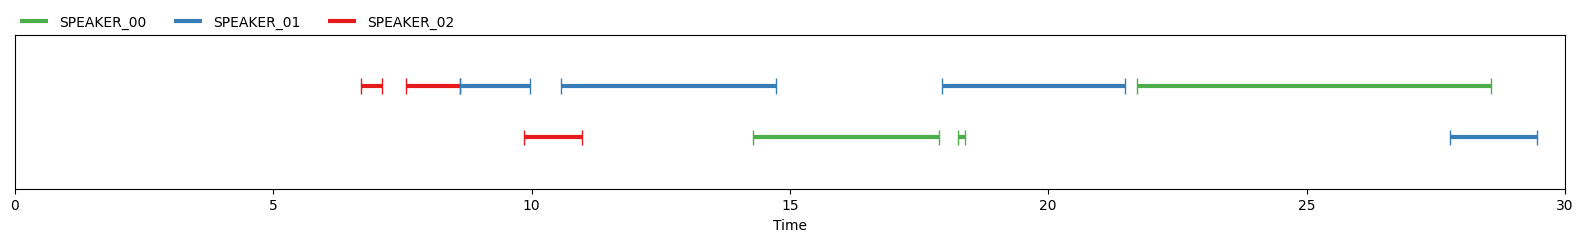

In [10]:
# 对[0, 30]时间范围进行可视化操作
from pyannote.core import notebook, Segment
notebook.crop = Segment(0, 30)
dia

When available, the reference annotation can be visualized too, for comparison:

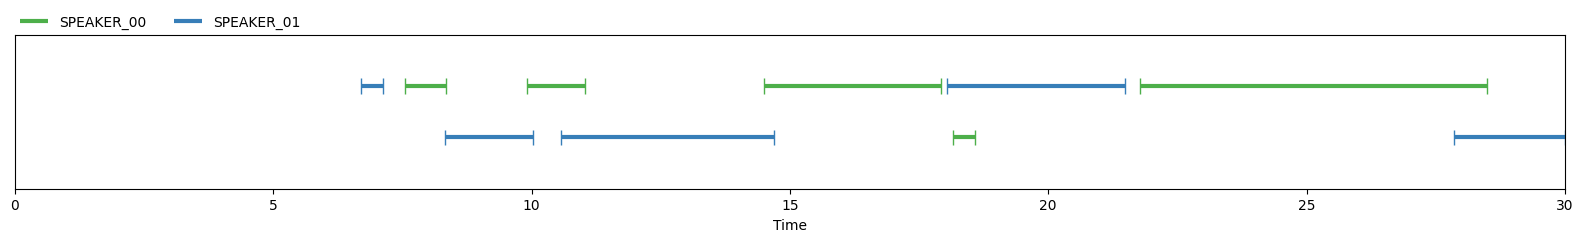

In [11]:
from pyannote.database.util import load_rttm
REFERENCE = f"{ROOT_DIR}/tutorials/assets/sample.rttm"
reference = load_rttm(REFERENCE)["sample"]

# map hypothesized and reference speakers for visualization purposes
pipeline.optimal_mapping(dia, reference)

### 4、从内存中处理一个文件

In case the audio file is not stored on disk, pipelines can also process audio provided as a `{"waveform": ..., "sample_rate": ...}` dictionary.

当音频文件不是存储在 `disk` 中的文件时，pipelines 同样可以处理表示为 `{"waveform": ..., "sample_rate": ...}` 字典数据格式的音频。

In [17]:
import torchaudio

waveform, sample_rate = torchaudio.load(AUDIO_FILE)

# 输出waveform的数据类型
print(f"{type(waveform)=}")
# print(type(waveform))

# 输出waveform的数据形状
print(f"{waveform.shape=}")

# 输出waveform中数据的数据类型
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

audio_in_memory

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 480000])
waveform.dtype=torch.float32


{'waveform': tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0028, -0.0006,  0.0019]]),
 'sample_rate': 16000}

Downloading: 100%|██████████| 277/277 [00:00<00:00, 99.3kB/s]
Downloading: 100%|██████████| 17.7M/17.7M [00:30<00:00, 587kB/s] 
Downloading: 100%|██████████| 1.98k/1.98k [00:00<00:00, 737kB/s]


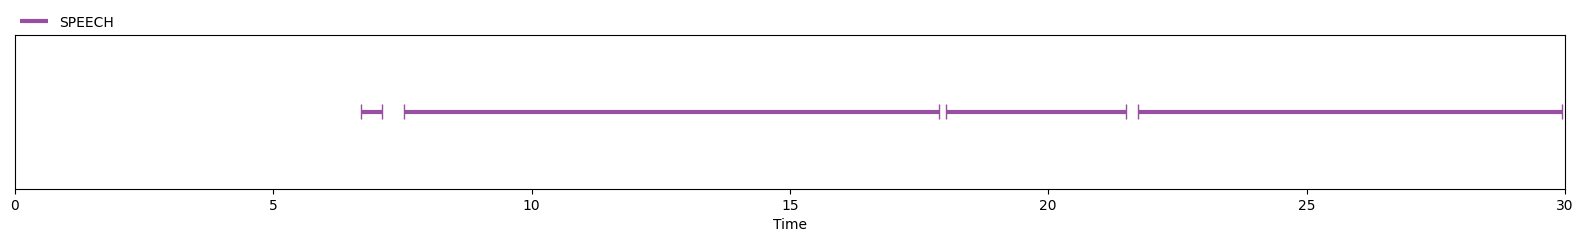

In [18]:
vad = Pipeline.from_pretrained("pyannote/voice-activity-detection")
vad(audio_in_memory)